### Setup environements and keyboard actor

In [1]:
import gym
import numpy as np

from src.envs.parsers.predator_prey import PredatorPrey_Parser

class KeyboardMAS():
    possible_actions = "sqzd "
    def __init__(self, n_agents):
        self.n_agents = n_agents

    def _str_actions_valid(self, str_actions):
        if (len(str_actions) != self.n_agents or 
                not all([str_actions[i] in self.possible_actions 
                         for i in range(len(str_actions))])):
            return False
        return True

    def _str_actions_to_numpy(self, str_actions):
        actions = [self.possible_actions.find(str_actions[i]) 
                   for i in range(self.n_agents)]
        return np.array(actions)

    def get_actions(self):
        while True:
            str_actions = input(f"Enter {self.n_agents} actions (valid actions are '{self.possible_actions}'):")
            if self._str_actions_valid(str_actions):
                break
            else:
                print("Invalid actions")
        return self._str_actions_to_numpy(str_actions)
    
class RandomMAS():
    def __init__(self, n_agents):
        self.n_agents = n_agents

    def get_actions(self):
        return np.random.randint(5, size=self.n_agents)
    
gym.envs.register(
    id='PredPrey5x5-v0',
    entry_point='src.envs.ma_gym.envs.predator_prey:PredatorPrey')
gym.envs.register(
    id='PredPrey7x7-v0',
    entry_point='src.envs.ma_gym.envs.predator_prey:PredatorPrey',
    kwargs={'grid_shape': (7, 7),
            'n_agents': 4, 
            'n_preys': 2})

# Pre-training language modules

In [3]:
import copy
import torch
import random
from torch import nn

from src.lmc.modules.lm import OneHotEncoder, GRUEncoder, GRUDecoder
from src.lmc.modules.obs import ObservationEncoder
from src.lmc.modules.lang_buffer import LanguageBuffer
    

class LanguageLearner:

    """ 
    Class to manage and train the language modules: the Language Encoder, the 
    Observation Encoder and the Decoder. 
    """

    def __init__(self, obs_dim, context_dim, hidden_dim, vocab, device="cpu", 
                 lr=0.007, n_epochs=2, batch_size=128, temp=1.0, 
                 clip_weight=1.0, capt_weight=1.0, obs_learn_capt=True, 
                 buffer_size=100000):
        self.train_device = device
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.temp = temp
        self.clip_weight = clip_weight
        self.capt_weight = capt_weight
        self.obs_learn_capt = obs_learn_capt

        self.word_encoder = OneHotEncoder(vocab)

        self.obs_encoder = ObservationEncoder(obs_dim, context_dim, hidden_dim)
        self.lang_encoder = GRUEncoder(context_dim, hidden_dim, self.word_encoder)
        self.decoder = GRUDecoder(context_dim, self.word_encoder)

        self.clip_loss = nn.CrossEntropyLoss()
        self.captioning_loss = nn.NLLLoss()

        self.optim = torch.optim.Adam(
            list(self.obs_encoder.parameters()) + 
            list(self.lang_encoder.parameters()) + 
            list(self.decoder.parameters()), 
            lr=lr)

        self.buffer = LanguageBuffer(buffer_size)

    def prep_rollout(self, device=None):
        if device is None:
            device = self.train_device
        self.obs_encoder.eval()
        self.obs_encoder.to(device)
        self.obs_encoder.device = device
        self.lang_encoder.eval()
        self.lang_encoder.to(device)
        self.lang_encoder.device = device
        self.decoder.eval()
        self.decoder.to(device)
        self.decoder.device = device

    def prep_training(self):
        self.obs_encoder.train()
        self.obs_encoder.to(self.train_device)
        self.obs_encoder.device = self.train_device
        self.lang_encoder.train()
        self.lang_encoder.to(self.train_device)
        self.lang_encoder.device = self.train_device
        self.decoder.train()
        self.decoder.to(self.train_device)
        self.decoder.device = self.train_device
    
    def store(self, obs, sent):
        self.buffer.store(obs, sent)

    def encode_sentences(self, sentence_batch):
        """ 
        Encode a batch of sentences. 
        :param sentence_batch (list(list(str))): Batch of sentences.

        :return context_batch (torch.Tensor): Batch of context vectors, 
            dim=(batch_size, context_dim).
        """
        context_batch = self.lang_encoder(sentence_batch).squeeze(0)
        return context_batch
    
    def encode_observations(self, obs_batch):
        context_batch = self.obs_encoder(obs_batch)
        return context_batch

    def generate_sentences(self, context_batch):
        """ 
        Generate sentences from a batch of context vectors. 
        :param context_batch (torch.Tensor): Batch of context vectors,
            dim=(batch_size, context_dim).
        
        :return gen_sent_batch (list(list(str))): Batch of generated sentences.
        """
        _, sentences = self.decoder(context_batch)
        return sentences

    def compute_losses(self, obs_batch, sent_batch):
        # Encode observations
        obs_tensor = torch.from_numpy(np.array(obs_batch, dtype=np.float32))
        obs_context_batch = self.obs_encoder(obs_tensor)

        # Encode sentences
        lang_context_batch = self.lang_encoder(sent_batch)
        lang_context_batch = lang_context_batch.squeeze()

        # Compute similarity
        norm_context_batch = obs_context_batch / obs_context_batch.norm(
            dim=1, keepdim=True)
        lang_context_batch = lang_context_batch / lang_context_batch.norm(
            dim=1, keepdim=True)
        sim = norm_context_batch @ lang_context_batch.t() * self.temp
        mean_sim = sim.diag().mean()

        # Compute CLIP loss
        labels = torch.arange(len(obs_batch)).to(self.train_device)
        loss_o = self.clip_loss(sim, labels)
        loss_l = self.clip_loss(sim.t(), labels)
        clip_loss = (loss_o + loss_l) / 2
        
        # Decoding
        encoded_targets = self.word_encoder.encode_batch(sent_batch)
        if not self.obs_learn_capt:
            obs_context_batch = obs_context_batch.detach()
        decoder_outputs, _ = self.decoder(obs_context_batch, encoded_targets)

        # Compute Captioning loss
        dec_loss = 0
        for d_o, e_t in zip(decoder_outputs, encoded_targets):
            e_t = torch.argmax(e_t, dim=1).to(self.train_device)
            dec_loss += self.captioning_loss(d_o[:e_t.size(0)], e_t)
        
        return clip_loss, dec_loss, mean_sim

    def train(self):
        clip_losses = []
        dec_losses = []
        mean_sims = []
        for it in range(self.n_epochs):
            self.optim.zero_grad()
            # Sample batch from buffer
            obs_batch, sent_batch = self.buffer.sample(self.batch_size)

            # Compute losses
            clip_loss, dec_loss, mean_sim = self.compute_losses(obs_batch, sent_batch)

            # Update
            tot_loss = self.clip_weight * clip_loss + self.capt_weight * dec_loss
            tot_loss.backward()
            self.optim.step()

            clip_losses.append(clip_loss.item() / self.batch_size)
            dec_losses.append(dec_loss.item() / self.batch_size)
            mean_sims.append(mean_sim.item())
        
        
        clip_loss = sum(clip_losses) / len(clip_losses)
        dec_loss = sum(dec_losses) / len(dec_losses)
        mean_sim = sum(mean_sims) / len(mean_sims)
        
        return clip_loss, dec_loss, mean_sim

    def get_save_dict(self):
        save_dict = {
            "obs_encoder": self.obs_encoder.state_dict(),
            "lang_encoder": self.lang_encoder.state_dict(),
            "decoder": self.decoder.state_dict(),
            "optim": self.optim.state_dict()}
        return save_dict

In [7]:
from src.log.progress_bar import Progress

def pretrain_language(env, parser, actor, lang_learner, n_steps=10000, print_progress=True):
    if print_progress:
        progress = Progress(n_steps)
    
    clip_losses, capt_losses, mean_sims = [], [], []
    step_i = 0
    obs = env.reset()
    while step_i < n_steps:
        if print_progress:
            progress.print_progress(step_i)
        # Parse obs
        sent = parser.parse_observations(obs)
        # Store in buffer
        lang_learner.store(obs, sent)
        # Sample actions
        actions = actor.get_actions()
        # Env step
        obs, rewards, dones, infos = env.step(actions)
        # End of episode
        if all(dones):
            clip_loss, capt_loss, mean_sim = lang_learner.train()
            if np.isnan(clip_loss) or np.isnan(capt_loss) or np.isnan(mean_sim):
                print("nan")
                return 1
            clip_losses.append(clip_loss)
            capt_losses.append(capt_loss)
            mean_sims.append(mean_sim)
            obs = env.reset()
        step_i += 1
    env.close()
    return clip_losses, capt_losses, mean_sims

In [4]:
import matplotlib.pyplot as plt

def plot_curves(curves, titles):
    """
    Inputs:
        curves (list(list(list(float)))): list of list of training curves, each element i of the main list is a list
            of all the training curves to plot in the subplot i.
    """
    nb_subplots = len(curves)
    
    fig, axs = plt.subplots(1, nb_subplots, figsize=(15,6))
    if type(axs) is not np.ndarray:
        axs = [axs]
    for ax, plot, title in zip(axs, curves, titles):
        max_len = max([len(c) for c in plot])
        for c in plot:
            c_len = len(c)
            if c_len == max_len:
                ax.plot(c)
            else:
                inter = max_len / c_len
                ax.plot((np.arange(c_len) + 1) * inter, c)
        ax.set_title(title)

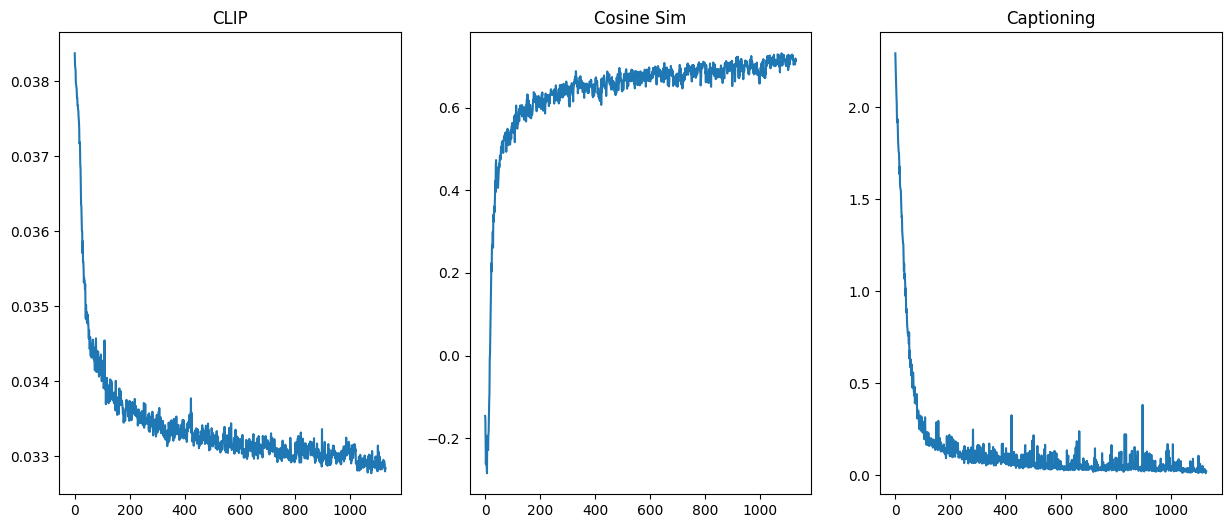

In [8]:
# Training parameters
n_steps = 100000
# Language parameters
context_dim = 16
hidden_dim = 32
lr = 0.007
batch_size = 128
clip_weight = 1.0
capt_weight = 1.0
obs_learn_capt = True
buffer_size = 100000

env = gym.make('PredPrey7x7-v0')
parser = PredatorPrey_Parser()
actor = RandomMAS(env.n_agents)

lang_learner = LanguageLearner(
    env.observation_space[0].shape[0], 
    context_dim, 
    hidden_dim, 
    parser.vocab,
    lr, 
    1, 
    batch_size, 
    1.0, 
    clip_weight, 
    capt_weight, 
    obs_learn_capt, 
    buffer_size)

clip_losses, capt_losses, mean_sims = pretrain_language(env, parser, actor, lang_learner, n_steps)

plot_curves([[clip_losses], [mean_sims], [capt_losses]], ["CLIP", "Cosine Sim", "Captioning"])

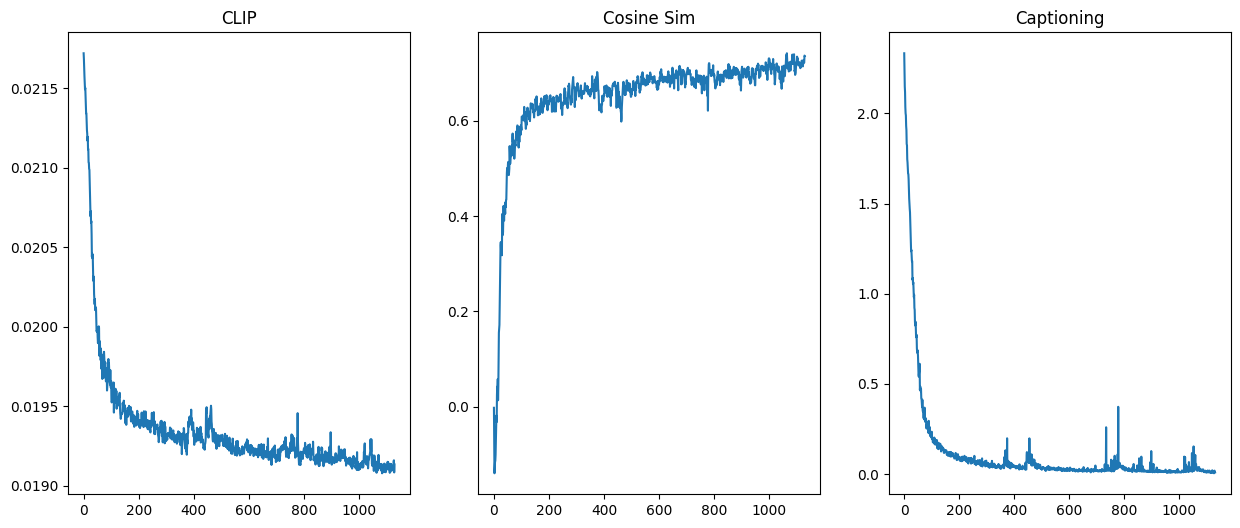

In [22]:
# Training parameters
n_steps = 100000
# Language parameters
context_dim = 16
hidden_dim = 32
lr = 0.007
batch_size = 128
clip_weight = 1.0
capt_weight = 1.0
obs_learn_capt = True
buffer_size = 100000

env = gym.make('PredPrey7x7-v0')
parser = PredatorPrey_Parser()
actor = RandomMAS(env.n_agents)

lang_learner = LanguageLearner(
    env.observation_space[0].shape[0], 
    context_dim, 
    hidden_dim, 
    parser.vocab,
    lr, 
    1, 
    batch_size, 
    1.0, 
    clip_weight, 
    capt_weight, 
    obs_learn_capt, 
    buffer_size)

clip_losses, capt_losses, mean_sims = pretrain_language(env, parser, actor, lang_learner, n_steps)

plot_curves([[clip_losses], [mean_sims], [capt_losses]], ["CLIP", "Cosine Sim", "Captioning"])

# Learning a communication policy using pretrained language modules

In [ ]:
def test_captioning(env, parser, actor, lang_learner, n_steps=100):
    progress = Progress(n_steps)
    step_i = 0
    obs = env.reset()
    while step_i < n_steps:
        progress.print_progress(step_i)
        # Parse obs
        sent = parser.parse_observations(obs)
        print(sent)
        # Store in buffer
        context = lang_learner.obs_encoder(torch.Tensor(obs))
        capt = lang_learner.generate_sentences(context)
        print(capt)
        # Sample actions
        actions = actor.get_actions()
        # Env step
        obs, rewards, dones, infos = env.step(actions)
        # End of episode
        if all(dones):
            obs = env.reset()
        input()
        step_i += 1
    env.close()

test_captioning(env, parser, actor, lang_learner)

### MLP Encoder in Communication Policy

In [14]:
import copy
import torch
import itertools
import numpy as np
import torch.nn.functional as F

from torch import nn

from src.lmc.modules.networks import MLPNetwork


def _cast(x):
    if len(x.shape) == 3:
        return x.transpose(1, 0, 2).reshape(-1, *x.shape[2:])
    elif len(x.shape) == 4:
        return x.transpose(1, 0, 2, 3).reshape(-1, *x.shape[2:])
    else:
        return x.transpose(1, 0, 2, 3, 4).reshape(-1, *x.shape[2:])

def _flatten(T, N, x):
    return x.reshape(T * N, *x.shape[2:])

def torch2numpy(x):
    return x.detach().cpu().numpy()
    

class CommBuffer_MLP:
    
    def __init__(self, context_dim, hidden_dim, max_sent_len, token_dim, gamma=0.99, n_mini_batch=2):
        self.context_dim = context_dim
        self.hidden_dim = hidden_dim
        self.max_sent_len = max_sent_len
        self.token_dim = token_dim
        assert gamma <= 1
        self.gamma = gamma
        self.n_mini_batch = n_mini_batch
        
        self.input_context = None
        self.generated_tokens = None
        self.token_log_probs = None
        self.value_preds = None
        self.returns = None
        self.masks = None
        
    def reset(self):
        self.input_context = None
        self.generated_tokens = None
        self.token_log_probs = None
        self.value_preds = None
        self.returns = None
        self.masks = None
        
    def store_gen(self, input_context, gen_tokens, token_log_probs, value_preds, masks):
        """
        Store a batch of generated sequences.
        """
        self.input_context = input_context
        self.generated_tokens = gen_tokens
        self.token_log_probs = token_log_probs
        self.value_preds = value_preds
        self.masks = masks            
    
    def compute_returns(self, step_rewards):
        """
        Compute returns at each step of generations from final rewards.
        :param rewards (np.ndarray): Rewards given for each generated sentences, dim=(seq_len, batch_size)
        """
        self.returns = step_rewards.copy()
        
        for s_i in reversed(range(self.returns.shape[0] - 1)):
            self.returns[s_i] = self.returns[s_i + 1] * self.gamma + step_rewards[s_i]
        self.returns = self.returns[..., np.newaxis]
        
    def recurrent_generator(self):
        """
        Randomise experiences and yields mini-batches to train.
        """
        # Each element of the batch is a data_chunk (one env step = generated sequence)
        batch_size = self.input_context.shape[0]
        assert batch_size % self.n_mini_batch == 0
        mini_batch_size = batch_size // self.n_mini_batch
        
        # Compute and normalise advantages
        advantages = self.returns[:-1] - self.value_preds[:-1]
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)
        
        # Return mini_batches with permutated indexes
        rand_ids = np.random.permutation(batch_size)
        sample_ids = [rand_ids[i * mini_batch_size:(i + 1) * mini_batch_size] for i in range(self.n_mini_batch)]
        for ids in sample_ids:
            yield self.input_context[ids], self.generated_tokens[:, ids], self.token_log_probs[:, ids], \
                  self.value_preds[:, ids], self.returns[:, ids], advantages[:, ids], self.masks[:, ids]

class TextActorCritic(nn.Module):
    
    def __init__(self, word_encoder, pretrained_decoder, context_dim, max_sent_len):
        super(TextActorCritic, self).__init__()
        self.word_encoder = word_encoder
        self.max_sent_len = max_sent_len
        # RNN encoder
        self.gru = copy.deepcopy(pretrained_decoder.gru)
        # Policy and value heads
        self.actor = copy.deepcopy(pretrained_decoder.out)
        self.critic = nn.Linear(context_dim, 1)
            
    def gen_messages(self, context_batch):
        """
        :param context_batch (torch.Tensor): Batch of context vectors,
                dim=(1, batch_size, context_dim).
        """
        batch_size = context_batch.shape[1]
        # Set initial hidden states and token
        hidden = context_batch
        last_tokens = torch.tensor(
            np.array([[self.word_encoder.SOS_ENC]])).float().repeat(1, batch_size, 1)
        
        batch_tokens = []
        batch_token_log_probs = []
        batch_value_preds = []
        batch_masks = [np.ones(batch_size)]
        last_topi = torch.zeros(batch_size)
        # batch_len_sentences = np.zeros(batch_size)
        sentences = [[] for b_i in range(batch_size)]
        for t_i in range(self.max_sent_len):
            # Encode with RNN
            _, hidden = self.gru(last_tokens, hidden)
            
            # Get token predictions from actor
            log_probs = self.actor(hidden)
            
            # Get values from critic
            value_preds = self.critic(hidden)
            
            # Sample next token
            _, topi = log_probs.topk(1)
            topi = topi.squeeze()
            tokens = self.word_encoder.token_encodings[topi]
            
            # Make token_log_prob
            token_log_probs = log_probs.gather(-1, topi.reshape(1, -1, 1))
            
            # Make mask: 1 if last token is not EOS and last mask is not 0
            masks = (np.where(last_topi == self.word_encoder.EOS_ID, 0.0, 1.0) * \
                     np.where(batch_masks[-1] == 0.0, 0.0, 1.0))
            last_topi = topi
            
            # Stop early if all sentences are finished
            if sum(masks) == 0:
                break
            
            # Add decoded tokens to sentences
            for b_i in range(batch_size):
                if masks[b_i]:
                    sentences[b_i].append(self.word_encoder.index2token(topi[b_i]))
            
            batch_tokens.append(tokens)
            batch_token_log_probs.append(torch2numpy(token_log_probs))
            batch_value_preds.append(torch2numpy(value_preds))
            batch_masks.append(masks)
            
            last_tokens = torch.Tensor(tokens).unsqueeze(0)
            
        # Compute last value
        _, hidden = self.gru(last_tokens, hidden)
        value_preds = self.critic(hidden)
        batch_value_preds.append(torch2numpy(value_preds))
        
        tokens = np.stack(batch_tokens, dtype=np.float32)
        token_log_probs = np.concatenate(batch_token_log_probs)
        value_preds = np.concatenate(batch_value_preds)
        masks = np.stack(batch_masks)
        
        return tokens, token_log_probs, value_preds, masks, sentences
    
    def evaluate_tokens(self, context_batch, token_batch):
        """
        Evaluate generated tokens with the current policy and value.
        :param context_batch (torch.Tensor): Batch of communication contexts (initial hidden state of gru), 
            dim=(1, batch_size, context_dim)
        :param token_batch (torch.Tensor): Batch of generated tokens, dim=(seq_len, batch_size, token_dim)
        
        :return token_log_probs (torch.Tensor): Log-probabilities of given tokens, dim=(seq_len, batch_size, 1)
        :return entropy (torch.Tensor): Entropy of the output probabilities, dim=(1)
        :return value_preds (torch.Tensor): Value predictions, dim=(seq_len, batch_size, 1)
        """
        # Add SOS token
        sos_tensor = torch.Tensor(np.array([self.word_encoder.SOS_ENC])).repeat(1, context_batch.shape[1], 1)
        input_tokens = torch.cat((sos_tensor, token_batch))
        
        outputs, _ = self.gru(input_tokens, context_batch)
        
        # Get log_probs and entropy
        log_probs = self.actor(outputs)
        token_log_probs = log_probs.gather(-1, token_batch.argmax(-1).unsqueeze(-1))
        entropy = -(log_probs * torch.exp(log_probs)).mean()

        # Get values
        value_preds = self.critic(outputs)

        return token_log_probs, entropy, value_preds

class CommPPO_MLP:
    """ 
    Communication module with a recurrent context encoder, 
    a policy that generates sentences and a value that estimates
    the quality of the current state (previous hidden state).
    It is trained using PPO, fine-tuning a pretrained policy.
    """
    def __init__(self, n_agents, context_dim, hidden_dim, lang_learner, 
                 lr=0.0005, ep_len=10, max_sent_len=12, n_envs=1, gamma=0.99,
                 n_epochs=16, clip_coef=0.2, entropy_coef=0.01, vloss_coef=0.5, 
                 klpretrain_coef=0.01, max_grad_norm=10.0, n_mini_batch=2):
        self.n_agents = n_agents
        self.context_dim = context_dim
        self.hidden_dim = hidden_dim
        self.n_envs = n_envs
        self.n_epochs = n_epochs
        self.clip_coef = clip_coef
        self.entropy_coef = entropy_coef
        self.vloss_coef = vloss_coef
        self.klpretrain_coef = klpretrain_coef
        self.max_grad_norm = max_grad_norm
        self.n_mini_batch = n_mini_batch
        
        self.lang_learner = lang_learner
        
        self.context_encoder = MLPNetwork(2 * context_dim, context_dim, norm_in=False)
        
        self.comm_policy = TextActorCritic(
            lang_learner.word_encoder, 
            lang_learner.decoder, 
            context_dim, 
            max_sent_len)
        
        self.optim = torch.optim.Adam(
            list(self.comm_policy.parameters()) + list(self.context_encoder.parameters()), 
            lr=lr, eps=1e-5)
        
        self.buffer = CommBuffer_MLP(
            context_dim, 
            hidden_dim, 
            max_sent_len, 
            self.lang_learner.word_encoder.enc_dim,
            gamma,
            n_mini_batch)
        
        self.last_comm = None
        
    def reset_episode(self):
        self.last_comm = None
    
    def save(self, path):
        pass
        
    @torch.no_grad()
    def get_messages(self, obs):
        """
        Perform a communication step: encodes obs and previous messages and
        generates messages for this step.
        :param obs (np.ndarray): agents' observations for all parallel 
            environments, dim=(n_envs, n_agents, obs_dim)
            
        :return comm (list(list(str))): messages generated for each agent,
            for each parallel environment
        :return lang_context (np.ndarray): language context vectors to send
            to policy, dim=(n_envs, n_agents, context_dim)
        """
        # Encode inputs
        obs_context = []
        obs = torch.Tensor(obs).view(self.n_envs * self.n_agents, -1)
        obs_context = self.lang_learner.encode_observations(obs)
        
        if self.last_comm is not None:
            sentences = list(itertools.chain.from_iterable(self.last_comm))
            lang_context = self.lang_learner.encode_sentences(sentences)
        else:
            lang_context = torch.zeros_like(obs_context)
            
        input_context = torch.cat((obs_context, lang_context), dim=-1)
        # Flatten rollout and agent dimensions
        #input_context = input_context.view(self.n_envs * self.n_agents, 2 * self.context_dim)
        
        # Encode contexts
        comm_context = self.context_encoder(input_context).unsqueeze(0)
        
        # Generate messages
        tokens, token_log_probs, value_preds, masks, sentences = self.comm_policy.gen_messages(comm_context)
        
        # Compute KL-pretrain rewards
        # Get reference token_log_probs from pretrained decoder
        ref_token_log_probs = self._get_pretrain_probs(comm_context, tokens)
        # Compute KL divergence
        klpretrain_rewards = -(token_log_probs - torch2numpy(ref_token_log_probs))
        
        # Store experiences in buffer
        self.buffer.store_gen(torch2numpy(input_context), tokens, token_log_probs, value_preds, masks)
        
        # Arrange sentences by env
        self.last_comm = [sentences[e_i * self.n_agents:(e_i + 1) * self.n_agents] for e_i in range(self.n_envs)]
        
        return self.last_comm, lang_context, klpretrain_rewards
        
    @torch.no_grad()
    def _get_pretrain_probs(self, context_batch, token_batch):
        """
        Get reference token log-probalities from pre-trained decoder.
        :param context_batch (np.ndarray): Batch of communication contexts (initial hidden state of gru), 
            dim=(1, batch_size, context_dim)
        :param token_batch (np.ndarray): Batch of generated tokens, dim=(seq_len, batch_size, token_dim)
        
        :return token_log_probs (torch.Tensor): Log-probabilities of given tokens, dim=(seq_len, batch_size, 1)
        :return entropy (torch.Tensor): Entropy of the output probabilities, dim=(1)
        :return value_preds (torch.Tensor): Value predictions, dim=(seq_len, batch_size, 1)
        """
        token_batch = torch.from_numpy(token_batch)
        # Add SOS token
        sos_token = np.tile(self.lang_learner.word_encoder.SOS_ENC, (1, context_batch.shape[1], 1))
        input_tokens = torch.Tensor(np.concatenate((sos_token, token_batch)))
        
        ref_log_probs, _ = self.lang_learner.decoder.forward_step(input_tokens, context_batch)
        ref_token_log_probs = ref_log_probs.gather(-1, token_batch.argmax(-1).unsqueeze(-1))
        return ref_token_log_probs
    
    def _store_rewards(self, message_rewards, klpretrain_rewards):
        """
        Send rewards for each sentences to the buffer to compute returns.
        :param message_rewards (np.ndarray): Rewards for each generated sentence, dim=(batch_size, )
        :param klpretrain_rewards (np.ndarray): Penalties for diverging from pre-trained decoder, 
            dim=(seq_len, batch_size, 1)
        """
        len_sentences = np.sum(self.buffer.masks, axis=0, dtype=int)
        step_rewards = np.zeros_like(self.buffer.masks)
        # Set final reward to final token of each sentence
        step_rewards[len_sentences - 1, list(range(message_rewards.shape[0]))] = message_rewards
        # Add klpretrain penalty
        step_rewards[1:] += self.klpretrain_coef * klpretrain_rewards.squeeze(-1)
        
        # Clean masked rewards
        step_rewards = step_rewards * self.buffer.masks
        
        self.buffer.compute_returns(step_rewards)
        
    def ppo_update(self, batch):
        input_context, generated_tokens, token_log_probs, value_preds, returns, advantages, masks = batch
        
        input_context = torch.from_numpy(input_context)
        generated_tokens = torch.from_numpy(generated_tokens)
        token_log_probs = torch.from_numpy(token_log_probs)
        advantages = torch.from_numpy(advantages)
        returns = torch.from_numpy(returns)
        
        # Evaluate generated tokens
        comm_context = self.context_encoder(input_context).unsqueeze(0)
        new_token_log_probs, entropy, new_value_preds = \
            self.comm_policy.evaluate_tokens(comm_context, generated_tokens)
            
        # Policy Loss
        ratio = (new_token_log_probs - token_log_probs).exp()
        pol_loss1 = -advantages * ratio
        pol_loss2 = -advantages * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
        pol_loss = torch.max(pol_loss1, pol_loss2).mean()
        
        # Entropy loss
        entropy_loss = entropy.mean()
        
        # Value loss
        val_loss = ((new_value_preds - returns) ** 2).mean()
        
        # Final loss
        loss = pol_loss - self.entropy_coef * entropy_loss + \
                self.vloss_coef * val_loss
        
        # Update
        self.optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.comm_policy.parameters(), self.max_grad_norm)
        nn.utils.clip_grad_norm_(self.context_encoder.parameters(), self.max_grad_norm)
        self.optim.step()
        
        return pol_loss, entropy_loss, val_loss
    
    def train(self):
        losses = {
            "policy_loss": 0,
            "entropy_loss": 0,
            "value_loss": 0}
        for e_i in range(self.n_epochs):
            data_generator = self.buffer.recurrent_generator()
            
            for train_batch in data_generator:
                pol_loss, entropy_loss, val_loss = self.ppo_update(train_batch)
                
                losses["policy_loss"] += pol_loss.item()
                losses["entropy_loss"] += entropy_loss.item()
                losses["value_loss"] += val_loss.item()
        
        for k in losses.keys():
            losses[k] /= (self.n_epochs * self.n_mini_batch)
            
        return losses
    
    def comm_step(self, obs):
        # Get messages
        messages, lang_context, klpretrain_rewards = self.get_messages(obs)
        
        # Get rewards
        message_rewards = np.zeros(self.n_envs * self.n_agents)
        rewards = {
            "comm": message_rewards.mean(),
            "klpretrain": klpretrain_rewards.mean()}
        
        # Store rewards
        self._store_rewards(message_rewards, klpretrain_rewards)
        
        # Train
        losses = self.train()
        
        # Return messages and lang_context
        return messages, lang_context, rewards, losses

Test two communication policies: one starting from scratch and one starting with parameters pretrained from language learning. Training the scratch policy to optimise only the klpretrain objective should end up like copying the pretrained decoder.

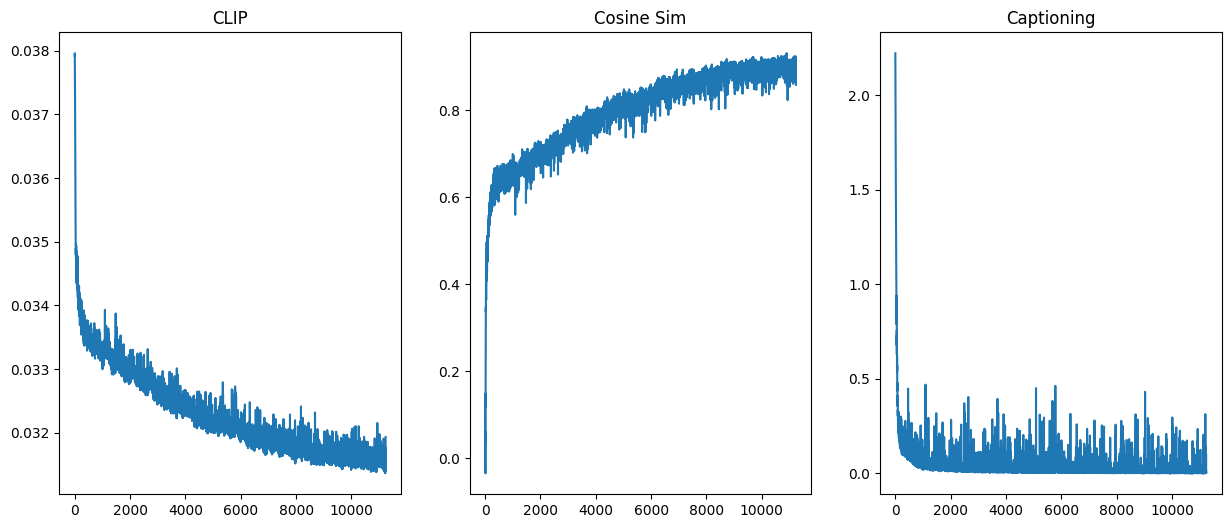

In [227]:
# Training parameters
n_steps = 1000000
# Language parameters
context_dim = 16
hidden_dim = 32
lr = 0.007
batch_size = 128
clip_weight = 1.0
capt_weight = 1.0
obs_learn_capt = True
buffer_size = 100000

env = gym.make('PredPrey7x7-v0')
parser = PredatorPrey_Parser()
actor = RandomMAS(env.n_agents)

pretrained_lang_learner = LanguageLearner(
    env.observation_space[0].shape[0], 
    context_dim, 
    hidden_dim, 
    parser.vocab,
    lr, 
    1, 
    batch_size, 
    1.0, 
    clip_weight, 
    capt_weight, 
    obs_learn_capt, 
    buffer_size)

clip_losses, capt_losses, mean_sims = pretrain_language(env, parser, actor, pretrained_lang_learner, n_steps)
plot_curves([[clip_losses], [mean_sims], [capt_losses]], ["CLIP", "Cosine Sim", "Captioning"])


pretrain_comm = CommPPO_MLP(env.n_agents, context_dim, hidden_dim, lang_learner, n_envs=N)

In [236]:
from tqdm import trange

lang_learner = LanguageLearner(
    env.observation_space[0].shape[0], 
    context_dim, 
    hidden_dim, 
    parser.vocab,
    lr, 
    1, 
    batch_size, 
    1.0, 
    clip_weight, 
    capt_weight, 
    obs_learn_capt, 
    buffer_size)

scratch_comm = CommPPO_MLP(env.n_agents, context_dim, hidden_dim, lang_learner, n_envs=N, klpretrain_coef=1.0)

# Training the "from scratch" strategy
reward = []
loss = []
for i in trange(100000):
    obs = np.random.random((N, env.n_agents, env.observation_space[0].shape[0]))
    messages, lang_context, rewards, losses = scratch_comm.comm_step(obs)
    reward.append(rewards)
    loss.append(losses)

100%|█████████████████████████████████| 100000/100000 [3:54:41<00:00,  7.10it/s]


In [15]:
from tqdm import trange

N = 32

scratch_comm = CommPPO_MLP(env.n_agents, context_dim, hidden_dim, lang_learner, n_envs=N, lr=0.0001, klpretrain_coef=1.0)

# Training the "from scratch" strategy
reward = []
loss = []
for i in trange(100000):
    obs = np.random.random((N, env.n_agents, env.observation_space[0].shape[0]))
    messages, lang_context, rewards, losses = scratch_comm.comm_step(obs)
    reward.append(rewards)
    loss.append(losses)

  2%|▋                                  | 1846/100000 [06:39<5:54:16,  4.62it/s]


KeyboardInterrupt: 

In [16]:
kr = [r["klpretrain"] for r in reward]

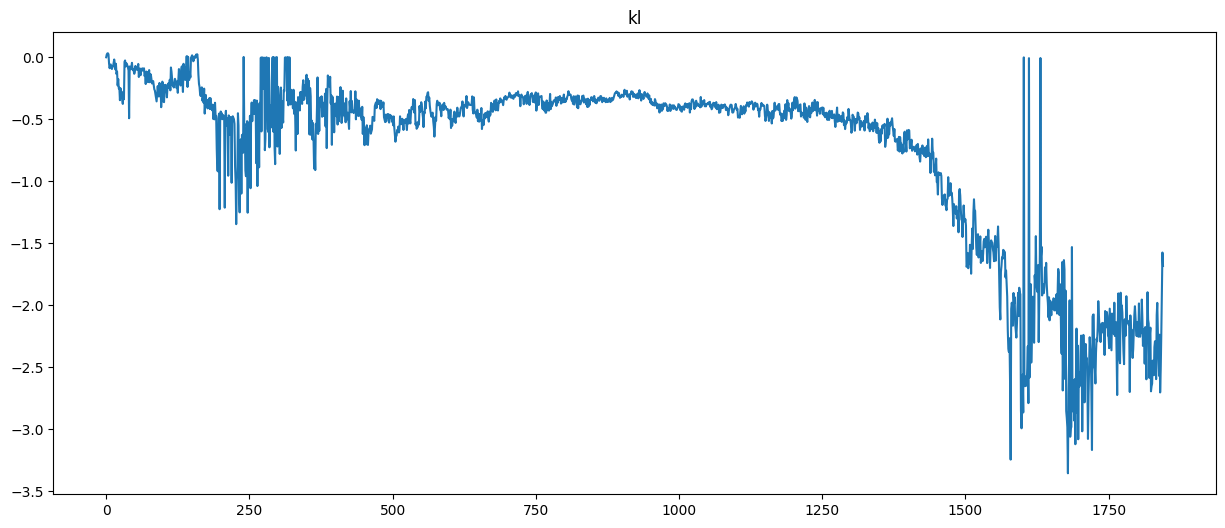

In [17]:
plot_curves([[kr]], ["kl"])

In [12]:
a = torch.zeros((2, 5))
a[1] = 1
a

tensor([[0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.]])

In [18]:
a.repeat(1, 4).reshape(8, 5)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [25]:
a= np.zeros((2, 5))
a[1] = 1
a.repeat(4, 0).reshape(8, 5)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [27]:
a= np.arange(10).reshape(2,5)

a.repeat(4, 0).reshape(8, 5)

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9],
       [5, 6, 7, 8, 9],
       [5, 6, 7, 8, 9],
       [5, 6, 7, 8, 9]])

## RNN Encoder in Communication Policy

In [291]:
import copy
import torch
import numpy as np
import torch.nn.functional as F

from torch import nn

from src.lmc.modules.networks import MLPNetwork


def _cast(x):
    if len(x.shape) == 3:
        return x.transpose(1, 0, 2).reshape(-1, *x.shape[2:])
    elif len(x.shape) == 4:
        return x.transpose(1, 0, 2, 3).reshape(-1, *x.shape[2:])
    else:
        return x.transpose(1, 0, 2, 3, 4).reshape(-1, *x.shape[2:])

def _flatten(T, N, x):
    return x.reshape(T * N, *x.shape[2:])

def torch2numpy(x):
    return x.detach().cpu().numpy()
    

class CommBuffer:
    
    def __init__(self, episode_len, context_dim, hidden_dim, max_sent_len, token_dim, n_envs=1):
        self.ep_len = episode_len
        self.context_dim = context_dim
        self.hidden_dim = hidden_dim
        self.max_sent_len = max_sent_len
        self.token_dim = token_dim
        self.n_envs = n_envs
        
        self.input_context = np.zeros(
            (episode_len + 1, n_envs, context_dim * 2),
            dtype=np.float32)
        
        self.encoder_rnn_states = np.zeros(
            (episode_len + 1, n_envs, hidden_dim),
            dtype=np.float32)
        
        self.generated_tokens = np.zeros(
            (episode_len, n_envs, max_sent_len, token_dim),
            dtype=np.float32)
        self.token_log_probs = np.zeros(
            (episode_len, n_envs, max_sent_len, token_dim),
            dtype=np.float32)
        
        self.value_preds = np.zeros(
            (episode_len + 1, n_envs, max_sent_len, 1),
            dtype=np.float32)
        self.returns = np.zeros(
            (episode_len + 1, n_envs, max_sent_len, 1),
            dtype=np.float32)
        
        self.rewards = np.zeros(
            (episode_len, n_envs, 1),
            dtype=np.float32)
        
        self.masks = np.ones(
            (episode_len + 1, n_envs, 1),
            dtype=np.float32)
        self.token_masks = np.ones(
            (episode_len + 1, n_envs, max_sent_len, 1),
            dtype=np.float32)
        
        self.step = 0
        
    def insert(self, input_context, encoder_rnn_states, generated_tokens, 
               token_log_probs, value_preds, rewards, masks, token_masks):
        self.input_context[self.step + 1] = input_context.copy()
        self.encoder_rnn_states[self.step + 1] = encoder_rnn_states.copy()
        self.generated_tokens[self.step + 1] = generated_tokens.copy()
        self.token_log_probs[self.step + 1] = token_log_probs.copy()
        self.value_preds[self.step + 1] = value_preds.copy()
        self.rewards[self.step + 1] = rewards.copy()
        self.masks[self.step + 1] = masks.copy()
        self.token_masks[self.step + 1] = token_masks.copy()
        self.step += 1
        
    def reset_episode(self):
        self.input_context = np.zeros((self.ep_len + 1, self.n_envs, self.context_dim * 2),dtype=np.float32)
        self.encoder_rnn_states = np.zeros((self.ep_len + 1, self.n_envs, self.hidden_dim),dtype=np.float32)
        self.generated_tokens = np.zeros((self.ep_len, self.n_envs, self.max_sent_len, self.token_dim),dtype=np.float32)
        self.token_log_probs = np.zeros((self.ep_len, self.n_envs, self.max_sent_len, self.token_dim),dtype=np.float32)
        self.value_preds = np.zeros((self.ep_len + 1, self.n_envs, 1),dtype=np.float32)
        self.returns = np.zeros((self.ep_len + 1, self.n_envs, 1),dtype=np.float32)
        self.rewards = np.zeros((self.ep_len, self.n_envs, self.max_sent_len, self.token_dim),dtype=np.float32)
        self.masks = np.ones((self.ep_len + 1, self.n_envs, 1),dtype=np.float32)
        self.token_mask = np.ones((self.ep_len + 1, self.n_envs, self.max_sent_len, 1),dtype=np.float32)
        self.step = 0
    
    def recurrent_generator(self, advantages, num_mini_batch):
        # Each element of the batch is a data_chunk (one env step = generated sequence)
        batch_size = self.n_envs * self.ep_len
        # data_chunks = batch_size // data_chunk_length
        mini_batch_size = batch_size // num_mini_batch
        
        rand = torch.randperm(batch_size).numpy()
        sampler = [rand[i * mini_batch_size:(i + 1) * mini_batch_size] for i in range(num_mini_batch)]

        input_context = _cast(self.input_context[:-1])
        encoder_rnn_states = _cast(self.encoder_rnn_states[:-1])
        generated_tokens = _cast(self.generated_tokens)
        token_log_probs = _cast(self.token_log_probs)
        value_preds = _cast(self.value_preds[:-1])
        returns = _cast(self.returns[:-1])
        masks = _cast(self.masks[:-1])
        token_masks = _cast(self.token_masks[:-1])
        
        for ids in sampler:
            input_context_batch = input_context[ids]
            generated_tokens_batch = generated_tokens[ids]
            value_preds_batch = value_preds[ids]
            returns_batch = returns[ids]
            masks_batch = masks[ids]
            token_log_probs_batch = token_log_probs[ids]
            adv_targ = advantages[ids]
            encoder_rnn_states_batch = encoder_rnn_states[ids]
            
            yield input_context_batch, encoder_rnn_states_batch, \
                  generated_tokens_batch, value_preds_batch, returns_batch, masks_batch, token_log_probs_batch, \
                  adv_targ
    
# TODO: orthogonal init of weights comme https://github.com/vwxyzjn/ppo-implementation-details/blob/main/ppo_atari_lstm.py#L112
# TODO: init rnn weigths: weights orthogonal, bias constant 0
# TODO: anneal learning rates
# Add layer norm all over the place

class RNNContextEncoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(ContextEncoder, self).__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim)
        
    def forward(self, x, rnn_state):
        x = F.relu(self.input(x))
        
        x = x.unsqueeze(0)
        
        x, new_rnn_state = self.gru(x, rnn_state)
        
        return x, new_rnn_state

class TextActorCritic(nn.Module):
    
    def __init__(self, word_encoder, pretrained_decoder, context_dim, max_sent_len):
        super(TextActorCritic, self).__init__()
        self.word_encoder = word_encoder
        self.max_sent_len = max_sent_len
        # RNN encoder
        self.gru = copy.deepcopy(pretrained_decoder.gru)
        # Policy and value heads
        self.actor = copy.deepcopy(pretrained_decoder.out)
        self.critic = nn.Linear(context_dim, 1)
        
    def get_value(self):
        pass
    
    def get_action_and_value(self, context):
        pass
            
    def gen_messages(self, context_batch):
        """
        :param context_batch (torch.Tensor): Batch of context vectors,
                dim=(batch_size, context_dim).
        """
        batch_size = context_batch.shape[1]
        # Set initial hidden states and token
        hidden = context_batch
        last_tokens = torch.tensor(
            np.array([[self.word_encoder.SOS_ENC]])).float().repeat(batch_size, 1, 1)
        
        batch_tokens = [last_tokens.squeeze()]
        batch_log_probs = []
        batch_value_preds = []
        batch_masks = [torch.ones(batch_size)]
        sentences = [[] for b_i in range(batch_size)]
        for t_i in range(self.max_sent_len):
            # Encode with RNN
            _, hidden = self.gru(last_tokens, hidden)
            # Get token predictions from actor
            log_probs = self.actor(hidden)
            # Get values from critic
            value_preds = self.critic(hidden)
            # Sample next token
            _, topi = log_probs.topk(1)
            topi = topi.squeeze()
            tokens = self.word_encoder.token_encodings[topi]
            last_tokens = torch.Tensor(tokens).unsqueeze(1)
            # Make mask
            masks = torch.where(topi == self.word_encoder.EOS_ID, 0.0, 1.0) * \
                    np.where(batch_masks[-1] == 0.0, 0.0, 1.0)
            # Add decoded tokens to sentences
            for b_i in range(batch_size):
                if batch_masks[-1][b_i]:
                    sentences[b_i].append(self.word_encoder.index2token(topi[b_i]))
            # Store
            batch_tokens.append(tokens)
            batch_log_probs.append(torch2numpy(log_probs))
            batch_value_preds.append(torch2numpy(value_preds))
            batch_masks.append(torch2numpy(masks))
            
        # Compute last value
        _, hidden = self.gru(last_tokens, hidden)
        value_preds = self.critic(hidden)
        batch_value_preds.append(torch2numpy(value_preds))
        
        tokens = np.stack(batch_tokens)
        log_probs = np.concatenate(batch_log_probs)
        value_preds = np.concatenate(batch_value_preds)
        masks = np.stack(batch_masks)
        
        return tokens, log_probs, value_preds, masks, sentences
        
        

class CommPPO_RNN:
    """ 
    Communication module with a recurrent context encoder, 
    a policy that generates sentences and a value that estimates
    the quality of the current state (previous hidden state).
    It is trained using PPO, fine-tuning a pretrained policy.
    """
    def __init__(self, n_agents, context_dim, hidden_dim, lang_learner, 
                 lr=0.0005, ep_len=10, max_sent_len=12, n_envs=1):
        self.n_agents = n_agents
        self.context_dim = context_dim
        self.hidden_dim = hidden_dim
        self.n_envs = n_envs
        
        self.lang_learner = lang_learner
        
        self.context_encoder = ContextEncoder(2 * context_dim, context_dim)
        
        self.comm_policy = TextActorCritic(
            lang_learner.word_encoder, 
            lang_learner.decoder, 
            context_dim, 
            max_sent_len)
        
        self.optim = torch.optim.Adam(
            list(self.comm_policy.parameters()) + list(self.context_encoder.parameters()), 
            lr=lr, eps=1e-5)
        
        self.buffer = CommBuffer(
            ep_len, context_dim, hidden_dim, max_sent_len, 
            self.lang_learner.word_encoder.enc_dim, n_envs)
        
        self.last_comm = None
        self.comm_context = None
        
    def reset_episode(self):
        self.buffer.reset_episode()
        self.last_comm = None
        self.comm_context = None
        
    @torch.no_grad()
    def get_messages(self, obs):
        # Encode inputs
        obs_context = []
        for a_i in range(self.n_agents):
            obs_context.append(self.lang_learner.encode_observations(torch.Tensor(obs[:, a_i])))
        obs_context = torch.stack(obs_context, dim=1)
        #obs_context = self.lang_learner.encode_observations(torch.Tensor(obs))
        if self.last_comm is not None:
            lang_context = self.lang_learner.encode_sentences(self.last_comm)
        else:
            lang_context = torch.zeros_like(obs_context)
            
        full_context = torch.cat((obs_context, lang_context), dim=-1)
        # Flatten rollout and agent dimensions
        assert (self.n_envs, self.n_agents) == tuple(full_context.shape[:2])
        full_context = full_context.view(self.n_envs * self.n_agents, 2 * self.context_dim)
        
        # Encode contexts
        _, self.comm_context = self.context_encoder(full_context, self.comm_context)
        
        # Generate messages
        tokens, log_probs, value_preds, masks, sentences = self.comm_policy.gen_messages(self.comm_context)
        print("tokens", tokens.shape)
        print("log_probs", log_probs.shape)
        print("value_preds", value_preds.shape)
        print("masks", masks.shape)
        print("sentences", sentences)
        
        # Arrange sentences by env
        sentences = [sentences[e_i * self.n_agents:(e_i + 1) * self.n_agents] for e_i in range(self.n_envs)]
        
        return sentences, lang_context, tokens, log_probs, value_preds, masks
    
    def store(self, data):
        pass
    
    def _get_values(self, last_token, rnn_states, masks):
        values, _ = self.critic(last_token, rnn_states)
    
    @torch.no_grad()
    def compute_last_value(self):
        next_value = self._get_values()
    
    def train(self):
        pass
    
    def save(self, path):
        pass

In [293]:
N = 2
a = CommPPO_RNN(env.n_agents, context_dim, hidden_dim, lang_learner, n_envs=N)

obs = np.ones((N, env.n_agents, env.observation_space[0].shape[0]))
obs[1] -= 1
a.get_messages(obs)

tokens (13, 8, 10)
log_probs (12, 8, 10)
value_preds (13, 8, 1)
masks (13, 8)
sentences [['Located', 'West', 'Prey', 'Observed', 'South', 'West', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', 'West', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', 'West', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', 'West', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', '<EOS>']]

[['Located', 'West', 'Prey', 'Observed', 'South', 'West', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', 'West', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', 'West', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', 'West', '<EOS>']]

[['Located', 'West', 'Prey', 'Observed', 'South', '<EOS>'], ['Located', 'West', 'Prey', 'Observed', 'South', '<EOS>'], ['Located', 'West

In [178]:
t = TextActorCritic(lang_learner.word_encoder, lang_learner.decoder, context_dim, 12)
batch_size = 5
tokens, log_probs, value_preds, masks, sentences = t.get_messages(np.random.random((batch_size, context_dim)))
print("tokens", tokens.shape)
print("log_probs", log_probs.shape)
print("value_preds", value_preds.shape)
print("masks", masks.shape)
print("sentences", sentences)

tokens (13, 5, 10)
log_probs (12, 5, 10)
value_preds (13, 5, 1)
masks (13, 5)
sentences [['Prey', 'Observed', 'South', '<EOS>'], ['Prey', 'Observed', 'South', '<EOS>'], ['<EOS>'], ['<EOS>'], ['West', 'Prey', 'Observed', 'South', '<EOS>']]


In [77]:
g = nn.GRU(10, 4)
h = torch.zeros((1, 1, 4))
for i in range(2):
    out, h = g(torch.ones((1, 1, 10)), h)
    print(out, h)

tensor([[[-0.5500,  0.3956,  0.3047,  0.1791]]], grad_fn=<StackBackward0>) tensor([[[-0.5500,  0.3956,  0.3047,  0.1791]]], grad_fn=<StackBackward0>)
tensor([[[-0.7856,  0.5232,  0.4812,  0.1737]]], grad_fn=<StackBackward0>) tensor([[[-0.7856,  0.5232,  0.4812,  0.1737]]], grad_fn=<StackBackward0>)


In [78]:
f = copy.deepcopy(g)#nn.GRU(10, 4)
print(g(torch.ones(2, 1, 10)))

(tensor([[[-0.5500,  0.3956,  0.3047,  0.1791]],

        [[-0.7856,  0.5232,  0.4812,  0.1737]]], grad_fn=<StackBackward0>), tensor([[[-0.7856,  0.5232,  0.4812,  0.1737]]], grad_fn=<StackBackward0>))
